# Import and Setup

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import sys
import os
import datetime
import itertools

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd


mpl_configs = {
    'figure.figsize': [6.0, 6.0],
}
mpl.rcParams.update(mpl_configs)

In [2]:
data_dir = '../data'
models_dir = '../models'
dataplus = lambda x: os.path.join(data_dir, x)
modelsplus = lambda x: os.path.join(models_dir, x)

now = datetime.datetime.now().strftime("%Y-%m-%d")
dateplus = lambda x: "%s-%s" % (now, x)

In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Prints and plots the confusion matrix. Normalize printed values by setting `normalize=True`
    """
    fig, ax = plt.subplots(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix')
#     print(cm)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment='center', color='white' if cm[i,j]>thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

onehot_encoder = OneHotEncoder()
    
def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=1)
    onehot_true = onehot_encoder.fit_transform(y_test.reshape(-1, 1)).toarray()
    print('Test Set Accuracy = {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score = {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(onehot_true, pred_probs, average='macro')))
    if cm:
        classes = [labels[x] for x in onehot_encoder.categories_[0]]
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=classes)
        
from sklearn import metrics

def plot_multiclass_roc(clf, x_test, y_test, labels, figsize=(6, 6)):
    y_score = clf.predict_proba(x_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(len(labels)):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    for i in range(len(labels)):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], labels[i]))
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# Data

- **features**: data/features.csv
- **labels**: data/labels.csv
- **test**: data/test.csv

In [4]:
df_features = pd.read_csv(dataplus('features.csv'))
print('feature shape: ',df_features.shape)
df_labels = pd.read_csv(dataplus('labels.csv'))
print('labels shape: ',df_labels.shape)

feature shape:  (8128, 157)
labels shape:  (8128, 2)


In [5]:
precomputed_features = ['vect_'+str(i) for i in range(1,149)]
categorical_features = ['key']
binary_features = ['mode']
continuous_features = ['loudness','tempo','time_signature','duration']
text_features = ['tag','title']
discrete_features = ['mode','key','time_signature']

In [6]:
# get convert text labels to numerical labels
df_labels.genre = pd.Categorical(df_labels.genre)
df_labels['label'] = df_labels.genre.cat.codes
labels = dict(enumerate(df_labels.genre.cat.categories))
labels

{0: 'classic pop and rock',
 1: 'dance and electronica',
 2: 'folk',
 3: 'jazz and blues',
 4: 'metal',
 5: 'pop',
 6: 'punk',
 7: 'soul and reggae'}

In [7]:
# merge features and labels
df = df_features.join(df_labels, on='trackID', rsuffix='_', how='inner')
df = df.drop('trackID_',axis=1)
print('labelled data shape:', df.shape)

labelled data shape: (7716, 159)


## Data Processing

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

numerical_features = categorical_features + binary_features + continuous_features + precomputed_features
d = df[numerical_features+['label']] # remove null values
d = d.fillna(d.median()) # impute missing values with median

# normalisation 
for f in continuous_features+precomputed_features:
    scaler = MinMaxScaler()
    df[f] = scaler.fit_transform(df[f].values.reshape(-1,1)).reshape(-1)

# convert key to one-hot
d = d.join(pd.get_dummies(df.key).add_prefix('key_'))
d = d.drop('key',axis=1)

x = d.drop('label',axis=1).values
y = d['label']
feature_names = d.drop('label',axis=1).columns.tolist()
print('features shape:', x.shape)
print('labels shape:', y.shape)

features shape: (7716, 165)
labels shape: (7716,)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

def get_train_test_split(df, features, oversample=True):
    d = df[features]
    x = d.values
    y = df['label'].values

    x_train, x_test, y_train, y_test = train_test_split(x, y)
    
    if oversample:
        # handle class imbalance with oversampling
        sm = SMOTE()
        x_train, y_train = sm.fit_resample(x_train, y_train)

    return x_train, x_test, y_train, y_test

In [14]:
# from KBest based on Mutual Information
selected_features = ['vect_3', 'vect_4', 'vect_5', 'vect_6', 'vect_7', 'vect_8', 'vect_9', 'vect_11', 'vect_12', 'vect_15', 'vect_19', 'vect_21', 'vect_23', 'vect_24', 'vect_25', 'vect_26', 'vect_27', 'vect_28', 'vect_29', 'vect_30', 'vect_34', 'vect_37', 'vect_39', 'vect_42', 'vect_43', 'vect_44', 'vect_46', 'vect_47', 'vect_51', 'vect_55', 'vect_56', 'vect_57', 'vect_58', 'vect_59', 'vect_61', 'vect_62', 'vect_66', 'vect_67', 'vect_69', 'vect_71', 'vect_74', 'vect_75', 'vect_76', 'vect_77', 'vect_79', 'vect_81', 'vect_83', 'vect_85', 'vect_87', 'vect_88', 'vect_91', 'vect_92', 'vect_94', 'vect_95', 'vect_97', 'vect_102', 'vect_104', 'vect_105', 'vect_109', 'vect_110', 'vect_112', 'vect_113', 'vect_116', 'vect_117', 'vect_121', 'vect_122', 'vect_123', 'vect_125', 'vect_126', 'vect_129', 'vect_133', 'vect_135', 'vect_138', 'vect_139', 'vect_140', 'vect_141', 'vect_143', 'vect_145', 'vect_147', 'vect_148']

x_train, x_test, y_train, y_test = get_train_test_split(d, selected_features)

print('train shape:', x_train.shape)
print('test shape:', x_test.shape)

train shape: (9608, 80)
test shape: (1929, 80)


# Model Selection

Try a few baseline classifiers.

cross validating RandomForestClassifier ...
cross validating LinearSVC ...
cross validating GradientBoostingClassifier ...
cross validating LogisticRegression ...
cross validating MLPClassifier ...


<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

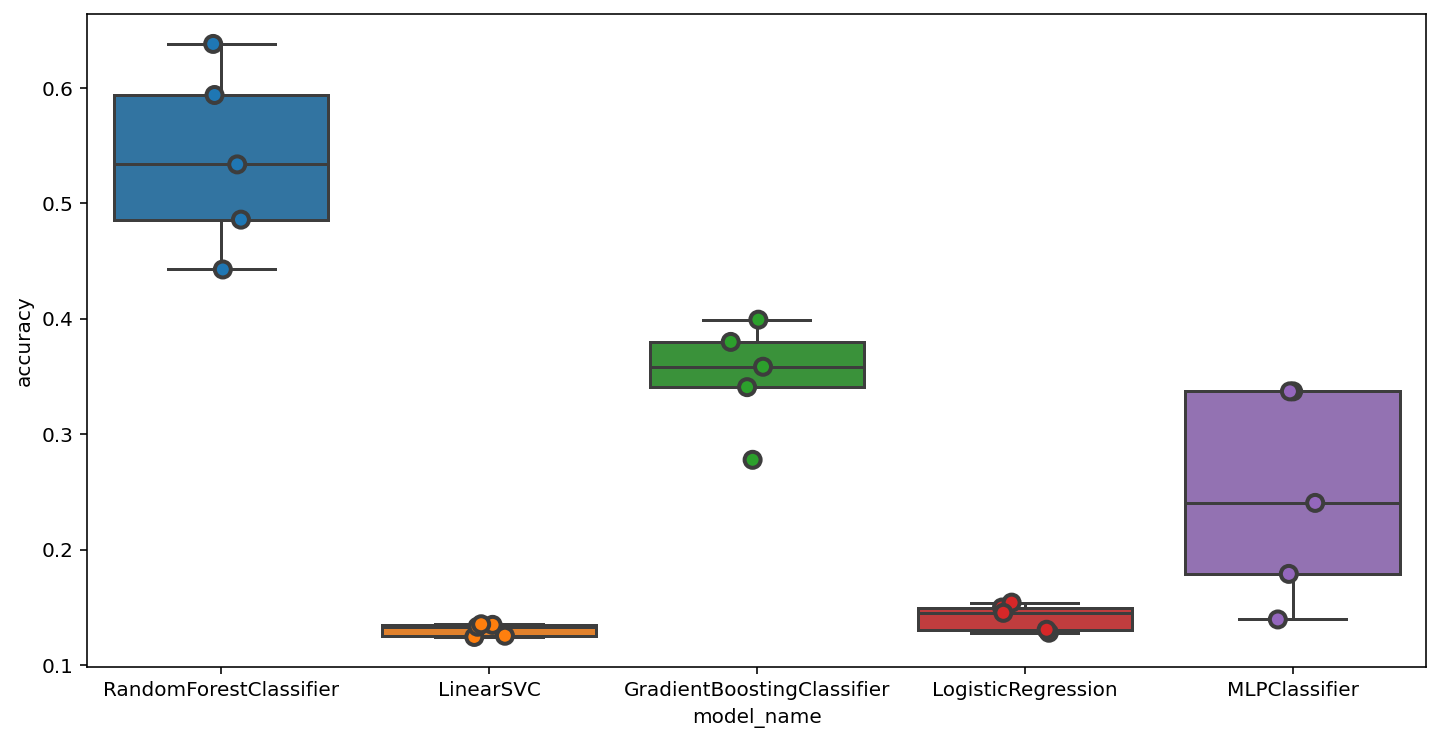

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, random_state=42),
    LinearSVC(),
    GradientBoostingClassifier(n_estimators=200, random_state=42),
    LogisticRegression(random_state=42),
    MLPClassifier(hidden_layer_sizes = [100]*5),
]

k = 5
entries = []

for model in models:
    model_name = model.__class__.__name__
    print('cross validating',model_name,'...')
    accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=k)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name','fold_idx','accuracy'])

fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x='model_name', y='accuracy', data=cv_df,ax=ax)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, ax=ax,
              size=8, jitter=True, edgecolor="gray", linewidth=2)

The random forest classifier has the best performance among the models.

## Validation of Random Forest Classifer

Test Set Accuracy = 0.16
Test Set F-score = 0.13
ROC AUC = 0.514
Confusion matrix


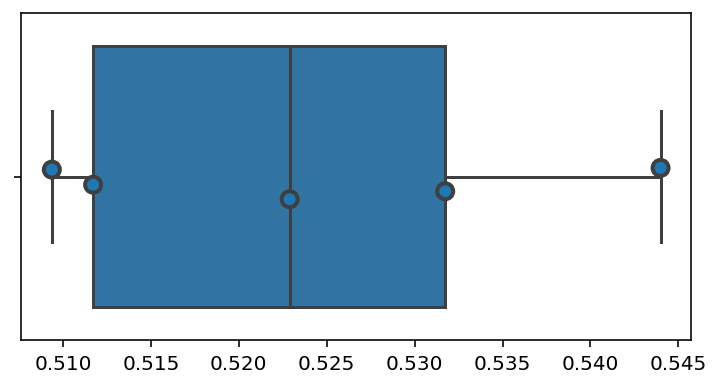

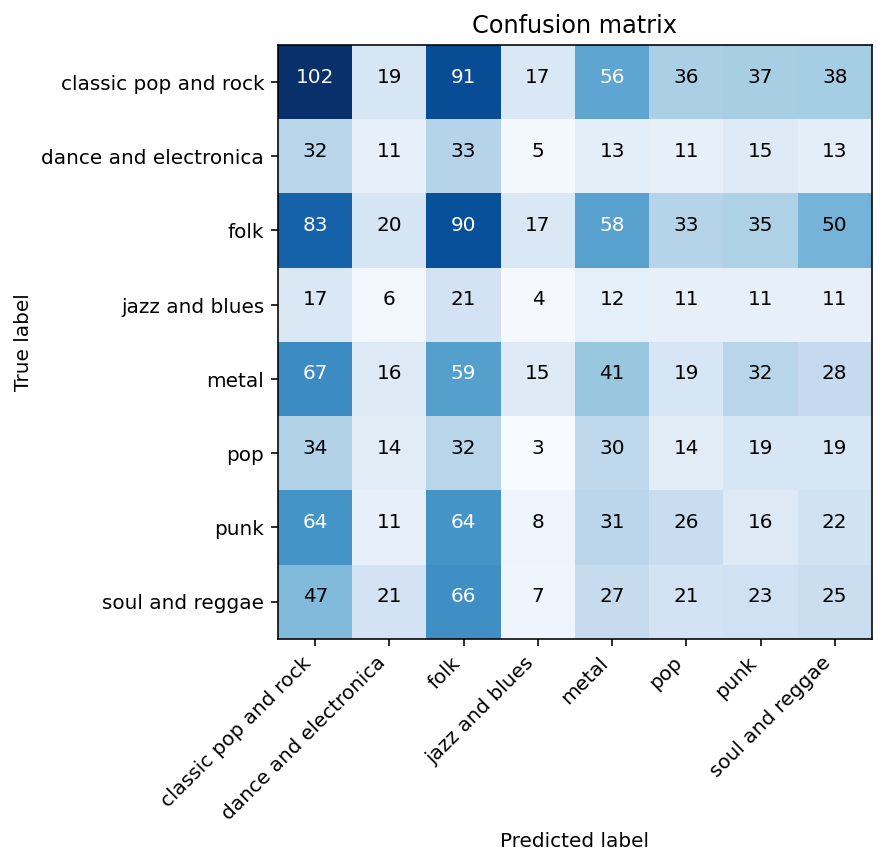

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

cv = KFold(n_splits=5, random_state=42, shuffle=True)

clf = RandomForestClassifier(n_estimators=200, random_state=42)

scores = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

fig, ax = plt.subplots(figsize=(6,3))
sns.boxplot(scores)
sns.stripplot(scores, ax=ax,size=8, jitter=True, edgecolor="gray", linewidth=2)

clf.fit(x_train, y_train)
pred_probs = clf.predict_proba(x_test)
display_results(y_test, pred_probs, cm=True)

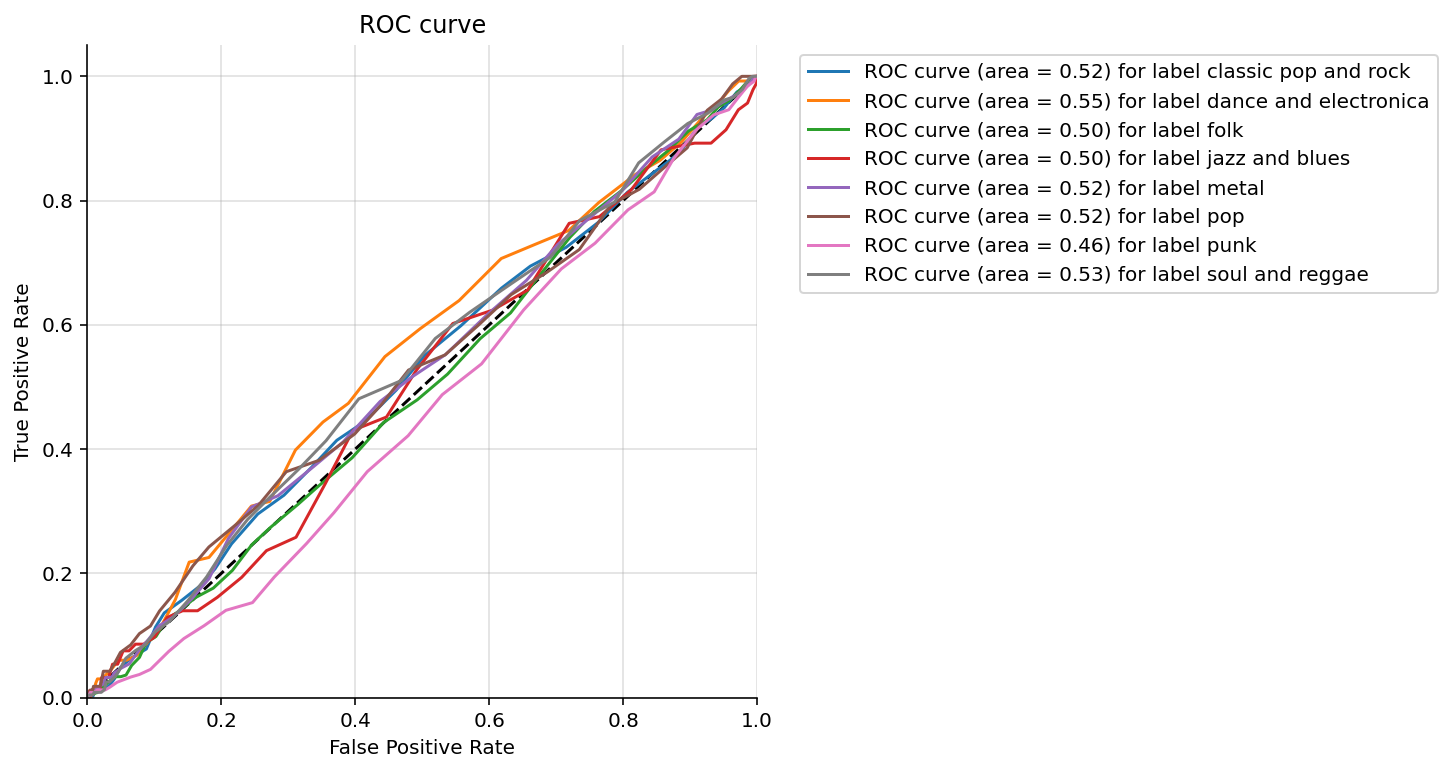

In [26]:
plot_multiclass_roc(clf,x_test, y_test, list(labels.values()))

# Hyperparameter Tuning of Random Forest Classifier

In [29]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [30]:
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(x_train, y_train)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}


Test Set Accuracy = 0.15
Test Set F-score = 0.12
ROC AUC = 0.500
Confusion matrix


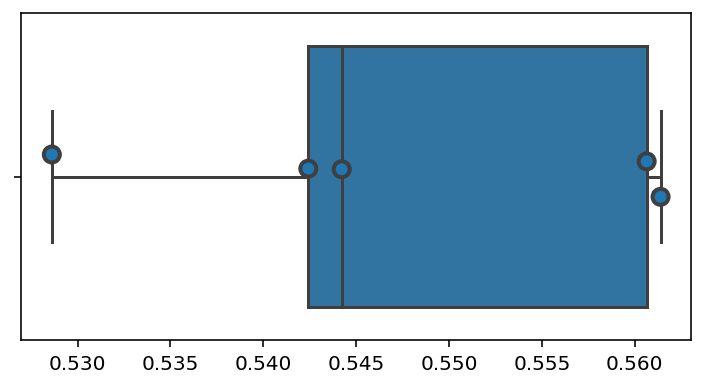

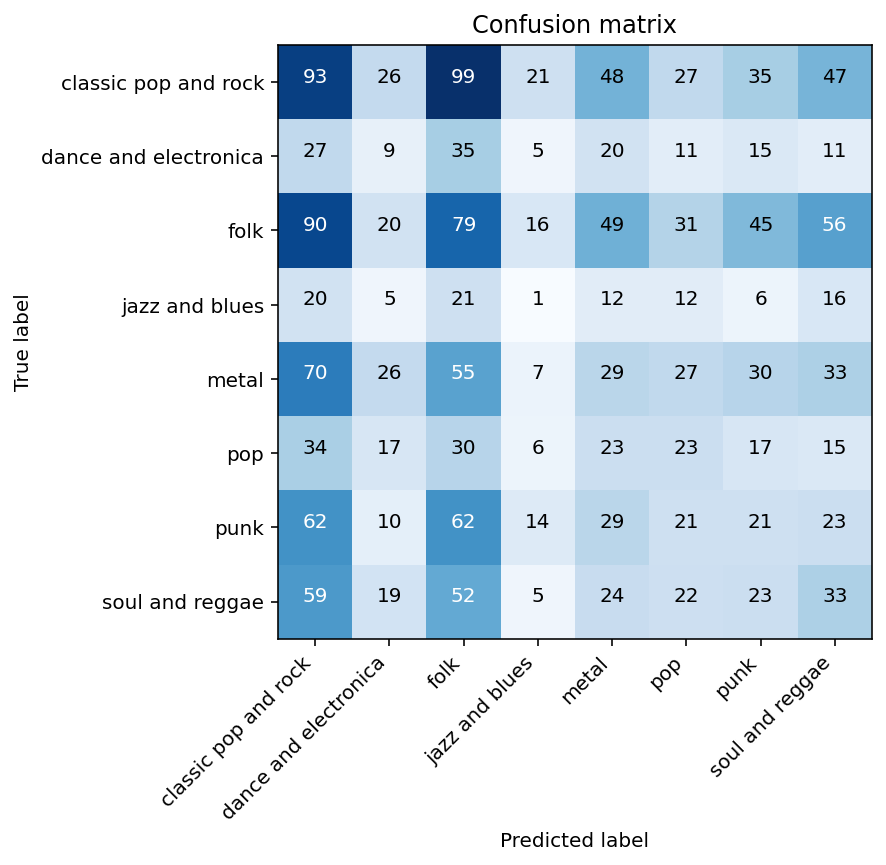

In [31]:
# RFC classifier using selected precomputed features
best_rf = rf_random.best_estimator_

scores = cross_val_score(best_rf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

fig, ax = plt.subplots(figsize=(6,3))
sns.boxplot(scores)
sns.stripplot(scores, ax=ax,size=8, jitter=True, edgecolor="gray", linewidth=2)

clf.fit(x_train, y_train)
pred_probs = clf.predict_proba(x_test)
display_results(y_test, pred_probs, cm=True)

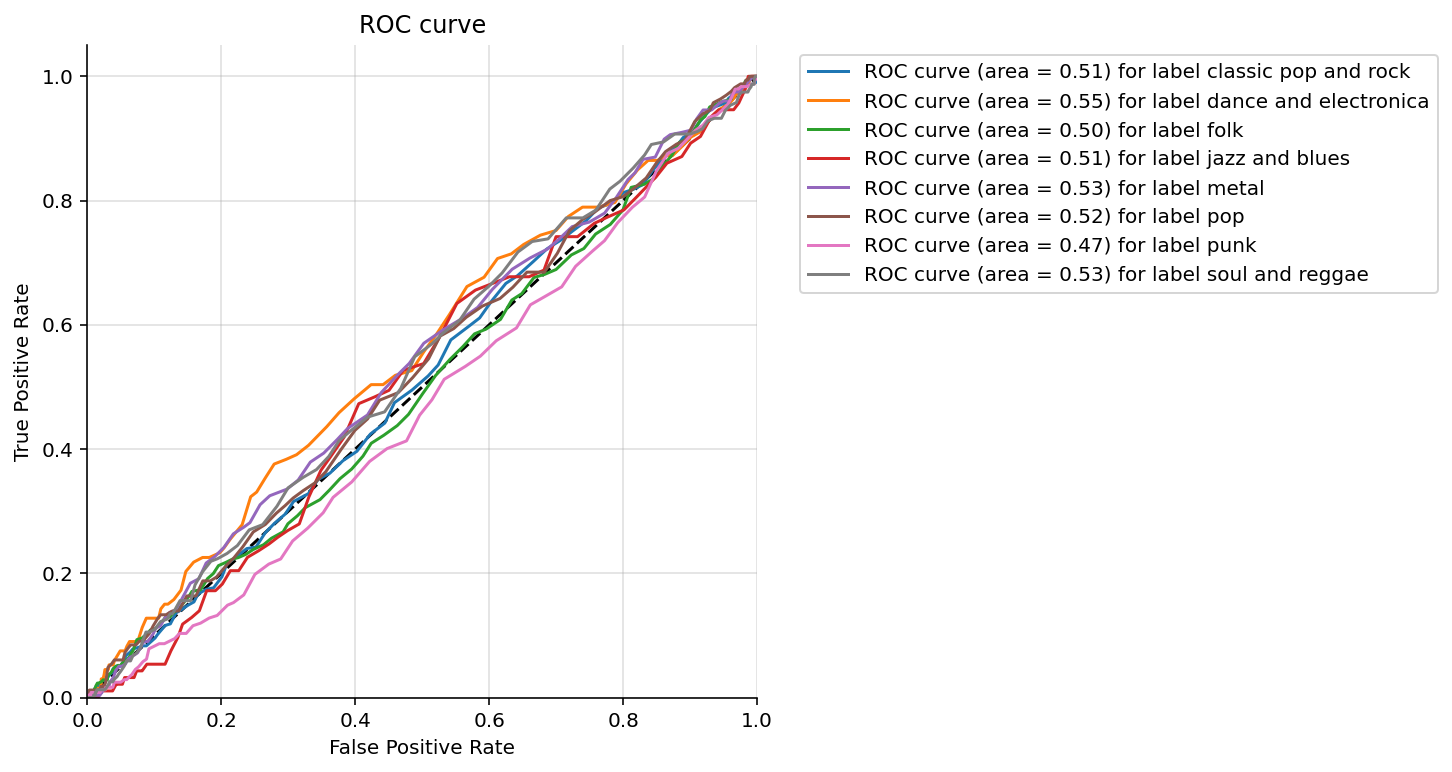

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 1.0min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  40.2s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  53.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time= 1.5min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time= 1.5min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time= 2.2min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time= 2.5min
[CV] END bootstrap=True, max_depth=None

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  16.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  54.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  41.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  32.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 1.4min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.8min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  47.9s
[CV] END bootstrap=True, max_depth=20, m

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  17.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.9min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.0min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time= 1.1min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=  58.9s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time= 2.5min
[CV] END bootstrap=True, max_depth=80

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 1.0min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  34.6s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  54.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 1.3min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.8min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time= 2.3min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 2.4min
[CV] END bootstrap=True, max_depth=None

In [32]:
plot_multiclass_roc(best_rf,x_test, y_test, list(labels.values()))